# Event detection with Recurrent Neural Networks - Part 1

In this fifth lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will use different types of Recurrent Neural Networks to detect events in noisy seismic recordings. This is a very important task in both Global and Applied Seismology: it can used in the former case to automatically analyse thousands seimograms recorded in Global Seismological Networks and extract signals associated to Earthquake activities, whilst it is relevant to the latter case in the context of Microseismic monitoring.

Whilst different approaches exist to accomplish this task, here we will train a network with synthetically generated seismograms such that we can also have access to ground truth labels. Moreover, whilst this problem can be framed as a regression task where we could try to estimate the start time and duration of an event, here we prefer to cast it as a segmentation task where the output is a binary time series of the same lenght of the input data where we wish to predict for each time sample if this is part of an event or not.

This notebook is organized as follows:

- synthetic data generation;
- training using a LSTM network with standard BCE loss;
- training using a LSTM network with a weighted BCE loss (aimed at compensating the fact that we have unbalanced labels - most time steps are not associated to an event);
- training using a Bidirectional-LSTM network with the same weighted BCE loss.

Moreover, whilst up until now we have been able to train our DNNs on a single CPU, this notebook serves also as an introduction to GPU training in PyTorch.

**NOTE**: various options exist to access a GPU. If you have a personal machine with a GPU you are lucky, take advantage of it. Alternatively, our IBEX cluster provides a large pool of nodes with different families of GPUs (RTX 2080, P6000, P100, V100). You can easily spin up a Jupyter Notebook and run this code by using the following [SLURM script](https://github.com/DIG-Kaust/MLgeoscience/blob/main/labs/jupyter_notebook_ibex.slurm). More details can be found [here](https://kaust-supercomputing-lab.atlassian.net/wiki/spaces/Doc/pages/88080449/Interactive+computing+using+Jupyter+Notebooks+on+KSL+platforms). 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import io
import os
import glob
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm_notebook as tqdm
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.metrics import accuracy_score, classification_report

import datacreation as dc

In [2]:
def set_seed(seed):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

Let's begin by checking we have access to a GPU and tell Torch we would like to use it:

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
set_seed(40)

True

Finally we set a flag that chooses whether we want to train our networks or load pre-trained ones. 

In this lab we will first train our networks and later simply load them if we want to just do some predictions on new data.

In [5]:
loadmodel = True
modelsdir = './'

## Data creation

To begin with we need to create a large variety of training data. Each training pair will be composed of a seismic trace and a trigger trace, where the latter is equal 1 in correspondance of the seismic event and 0 elsewhere.

The seismic trace is created as follows:

$$
s(t) = a * w(t;f) * r(t;t_0) + n(t, SNR)
$$

where the central frequency of the wavelet $f$, the time of the event $t_0$, and $SNR$ are randomly chosen for each trace. Moreover, some of the traces contain only noise, this is driven by the $a$ parameter. 

In [6]:
# Input paramters
nt = 500 # number of time samples
dt = 0.002 # time sampling
#SNR = [5., 10., -1., 4.] # signal to noise ratio paramters (min, max, skewness, mean) - low noise level
SNR = [2., 8., 4., 3.] # signal to noise ratio paramters (min, max, skewness, mean) - high noise level
noise_freq = [2, 40] # min and max frequency of noise
wavelet_freq = [20, 30] # min and max frequency of wavelet

ntraining = 500 # number of training samples
ntest = 50 # number of test samples

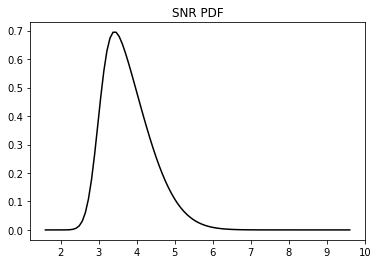

In [7]:
# Display SNR
plt.plot(*dc.pdf_snr(*SNR), 'k')
plt.title('SNR PDF');

In [8]:
# Create data
traindata = [dc.create_data(nt=nt, dt=dt,
                            snrparams=SNR, 
                            freqwav=wavelet_freq, 
                            freqbp=noise_freq, 
                            signal=True) 
             for i in tqdm(range(ntraining))]

testdata = [dc.create_data(nt=nt, dt=dt,
                           snrparams=SNR, 
                           freqwav=wavelet_freq, 
                           freqbp=noise_freq, 
                           signal=True) 
            for i in tqdm(range(ntest))]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
train_data_X = np.zeros([ntraining, nt, 1])
train_data_y = np.zeros([ntraining, nt])

for i, d in enumerate(traindata):  
    train_data_X[i, :, 0] = d['synthetic']
    train_data_y[i, :] = d['labels']

In [10]:
test_data_X = np.zeros([ntest, nt, 1])
test_data_y = np.zeros([ntest, nt])

for i, d in enumerate(testdata):  
    test_data_X[i, :, 0] = d['synthetic']
    test_data_y[i, :] = d['labels']

In [11]:
# percentage of 0 labels over 1 labels
scaling = np.round(np.mean([(nt-np.sum(traindata[i]['labels']))/np.sum(traindata[i]['labels']) for i in range(ntraining)]))
scaling

11.0

Let's take a look at the data we are going to work with

In [12]:
def plotting(X1, y1, X2, y2, title1, title2, y1prob=None, y2prob=None, dt=0.002, nplot=3):
    fig, axs = plt.subplots(nplot, 2, figsize=[15, nplot*2])
    nt = len(X1[0])
    for t in range(nplot):
        axs[t, 0].set_title(title1)
        axs[t, 0].plot(np.arange(nt)*dt, X1[t].squeeze(),'k')
        axs[t, 0].fill_between(np.arange(nt)*dt,
                               y1=1*y1[t].squeeze(), 
                               y2=-1*y1[t].squeeze(),
                               linewidth=0.0,
                               color='#E6DF44')
        if y1prob is not None:
            axs[t, 0].plot(np.arange(nt)*dt, y1prob[t].squeeze(), '#E6DF44', lw=2)

        axs[t, 1].set_title(title2)
        axs[t, 1].plot(np.arange(nt)*dt, X2[t].squeeze(),'k')
        axs[t, 1].fill_between(np.arange(nt)*dt,
                               y1=1*y2[t].squeeze(), 
                               y2=-1*y2[t].squeeze(),
                               linewidth=0.0,
                               color='#A2C523')
        if y2prob is not None:
            axs[t, 1].plot(np.arange(nt)*dt, y2prob[t].squeeze(), '#A2C523', lw=2)

    for ax in axs.ravel():
        ax.set_xlim([0,dt*nt])
        ax.set_ylim([-1,1])

    fig.tight_layout()

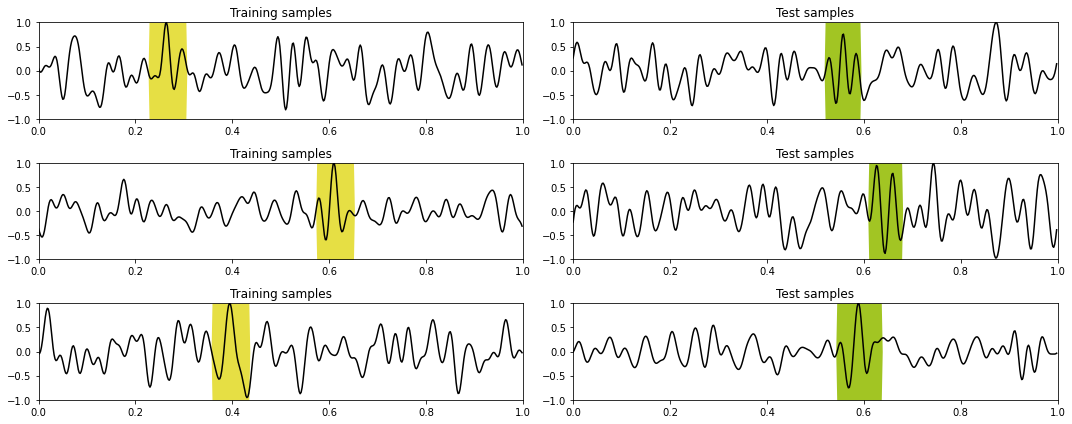

In [13]:
nplot = 3
plotting(train_data_X, train_data_y, test_data_X, test_data_y, 
         'Training samples', 'Test samples', dt=dt, nplot=3)

## Training

Let's now prepare some training routines similar to those we have already seen in the other labs.

In [14]:
def train(model, criterion, optimizer, data_loader, device='cpu'):
    model.train()
    accuracy = 0
    loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)            
        optimizer.zero_grad()
        yprob = model(X)
        ls = criterion(yprob.view(-1), y.view(-1))
        ls.backward()
        optimizer.step()
        y_pred = np.where(yprob.detach().cpu().numpy() > 0.5, 1, 0).astype(np.float32)
        loss += ls.item()
        accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.ravel())
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return loss, accuracy

In [15]:
def evaluate(model, criterion, data_loader, device='cpu'):
    model.eval()
    accuracy = 0
    loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)            
        with torch.no_grad(): # use no_grad to avoid making the computational graph...
            yprob = model(X)
            ls = criterion(yprob.view(-1), y.view(-1))
        y_pred = np.where(yprob.cpu().numpy() > 0.5, 1, 0).astype(np.float32)
        loss += ls.item()
        accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.ravel())
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return loss, accuracy

In [16]:
def predict(model, X, y, label, device='cpu', dt=0.002, nplot=5, report=False):
    model.eval()
    X = X.to(device)

    with torch.no_grad(): # use no_grad to avoid making the computational graph...
        yprob = nn.Sigmoid()(model(X))
    y_pred = np.where(yprob.cpu().numpy() > 0.5, 1, 0)
    
    if report:
        print(classification_report(y.ravel(), y_pred.ravel()))
    
    plotting(X.cpu().detach().numpy().squeeze(), 
             y, X.cpu().detach().numpy().squeeze(), 
             y_pred, y2prob=yprob.cpu().numpy(), 
             title1='True', title2=label, dt=dt, nplot=nplot)

In [17]:
def training(network, loss, optim, nepochs, train_loader, test_loader, 
             device='cpu', modeldir=None, modelname=''):
    iepoch_best = 0
    train_loss_history = np.zeros(nepochs)
    valid_loss_history = np.zeros(nepochs)
    train_acc_history = np.zeros(nepochs)
    valid_acc_history = np.zeros(nepochs)
    for i in range(nepochs):
        train_loss, train_accuracy = train(network, loss, optim, 
                                           train_loader, device=device)
        valid_loss, valid_accuracy = evaluate(network, loss, 
                                              test_loader, device=device)
        train_loss_history[i] = train_loss
        valid_loss_history[i] = valid_loss
        train_acc_history[i] = train_accuracy
        valid_acc_history[i] = valid_accuracy
        if modeldir is not None:
            if i == 0 or valid_accuracy > np.max(valid_acc_history[:i]):        
                iepoch_best = i
                torch.save(network.state_dict(), os.path.join(modeldir, 'models', model+'.pt'))
        if i % 10 == 0:
            print(f'Epoch {i}, Training Loss {train_loss:.3f}, Training Accuracy {train_accuracy:.3f}, Test Loss {valid_loss:.3f}, Test Accuracy {valid_accuracy:.3f}')
    return train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best

Similarly we define the two networks we are going to use

In [18]:
class LSTMNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(I, H, 1, batch_first=True)
        self.dense = nn.Linear(H, O, bias=False)
        
    def forward(self, x):
        z, _ = self.lstm(x)
        out = self.dense(z)
        return out.squeeze()

In [19]:
class BiLSTMNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(BiLSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(I, H, 1, batch_first=True, bidirectional=True)
        self.dense = nn.Linear(2*H, O, bias=False)
        
    def forward(self, x):
        z, _ = self.lstm(x)
        out = self.dense(z)
        return out.squeeze()

In [20]:
class DoubleBiLSTMNetwork(nn.Module):
    def __init__(self, I, He, Hd, O):
        super(DoubleBiLSTMNetwork, self).__init__()
        self.encoder = nn.LSTM(I, He, 1, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(2*He, Hd, batch_first=True)
        self.dense = nn.Linear(Hd, O, bias=False)
        
    def forward(self, x):
        # Encoder
        z, _ = self.encoder(x)
        # Decoder
        z2, _ = self.decoder(z)
        # Dense
        out = self.dense(z2)
        return out.squeeze()

We are finally ready to prepare the training and test data

In [21]:
# Define Train Set
X_train = torch.from_numpy(train_data_X).float()
y_train = torch.from_numpy(train_data_y).float()

train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_test = torch.from_numpy(test_data_X).float()
y_test = torch.from_numpy(test_data_y).float()

test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### LSTM with Standard BCE

Best epoch: 0, Valid accuracy: 0.92


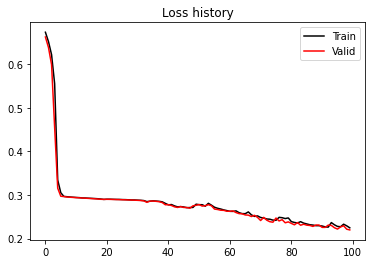

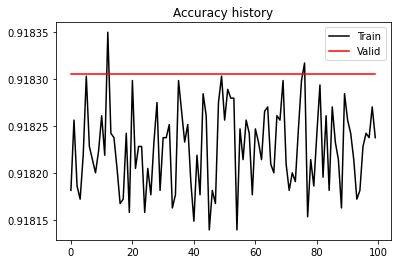

In [22]:
model = 'lstm_bce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network = LSTMNetwork(1, 200, 1)
    network.to(device)
    
    bce_loss = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(network.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network, bce_loss, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    # Load best model
    network = LSTMNetwork(1, 200, 1)
    network.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
    network.to(device)
    
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

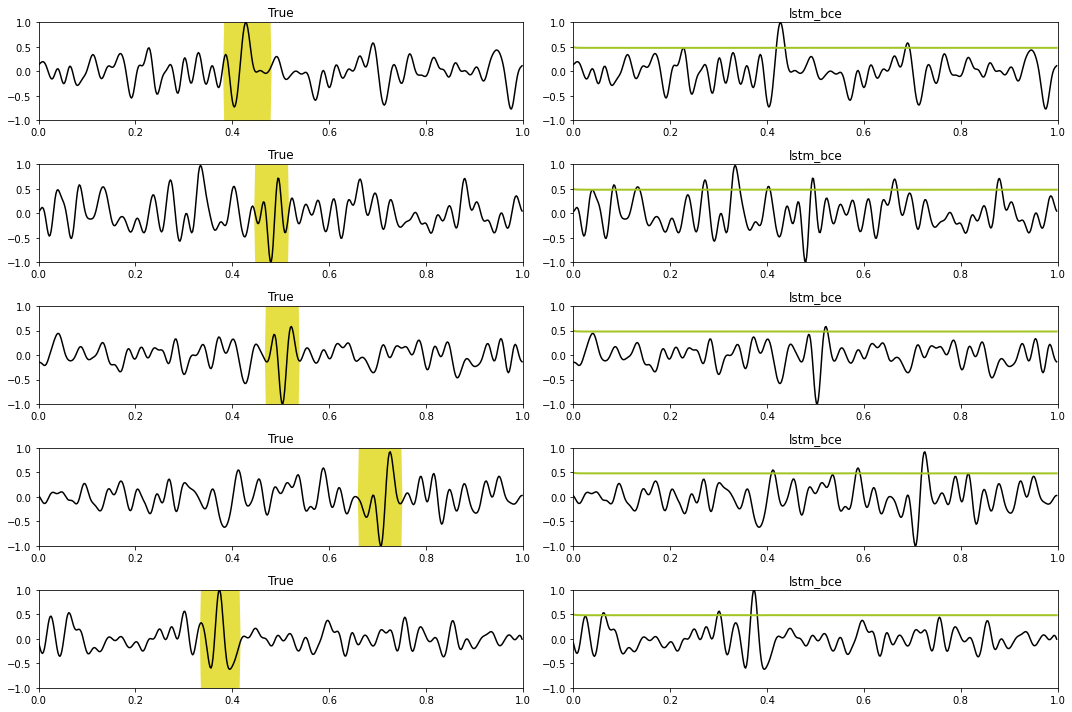

In [23]:
# Prediction train
X, y = next(iter(train_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

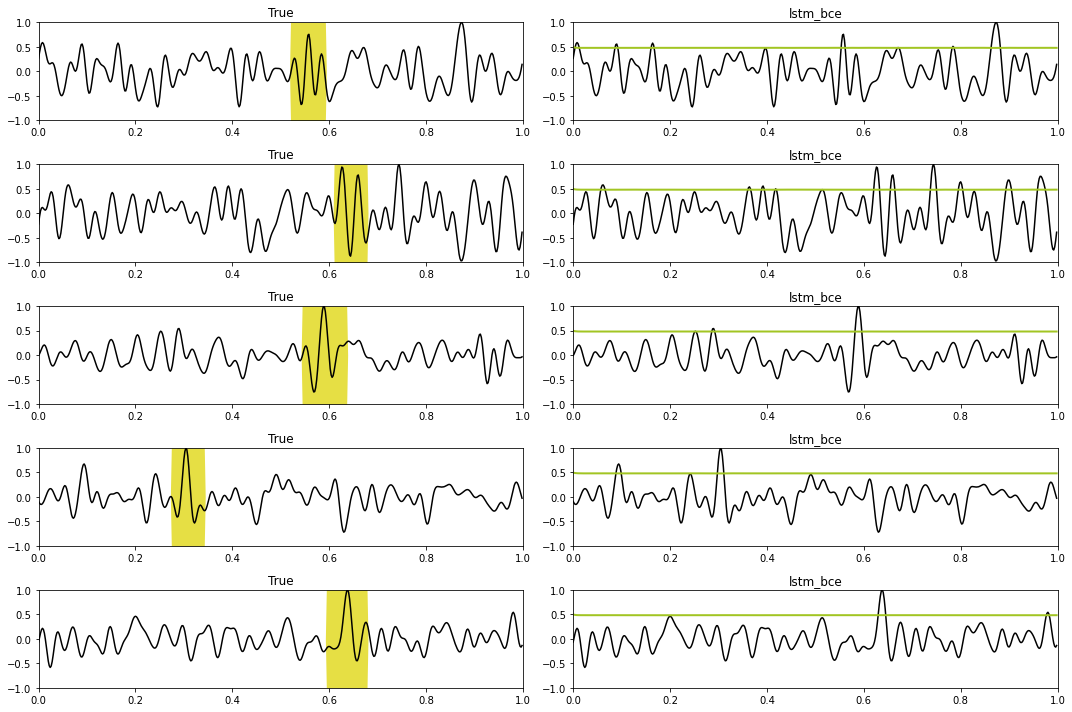

In [24]:
# Prediction test
X, y = next(iter(test_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

### LSTM with Weighted BCE

Best epoch: 45, Valid accuracy: 0.94


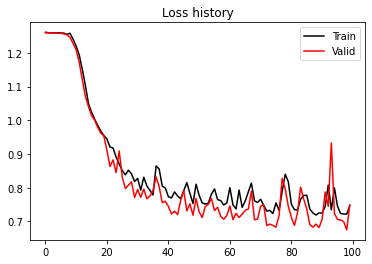

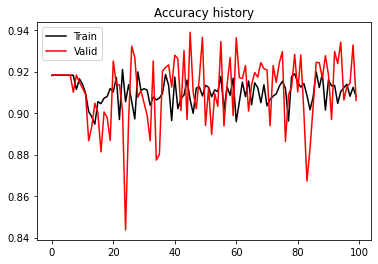

In [25]:
model = 'lstm_weightedbce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_w = LSTMNetwork(1, 200, 1)
    network_w.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network_w.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_w, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    # Load best model
    network_w = LSTMNetwork(1, 200, 1)
    network_w.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
    network_w.to(device)
    
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

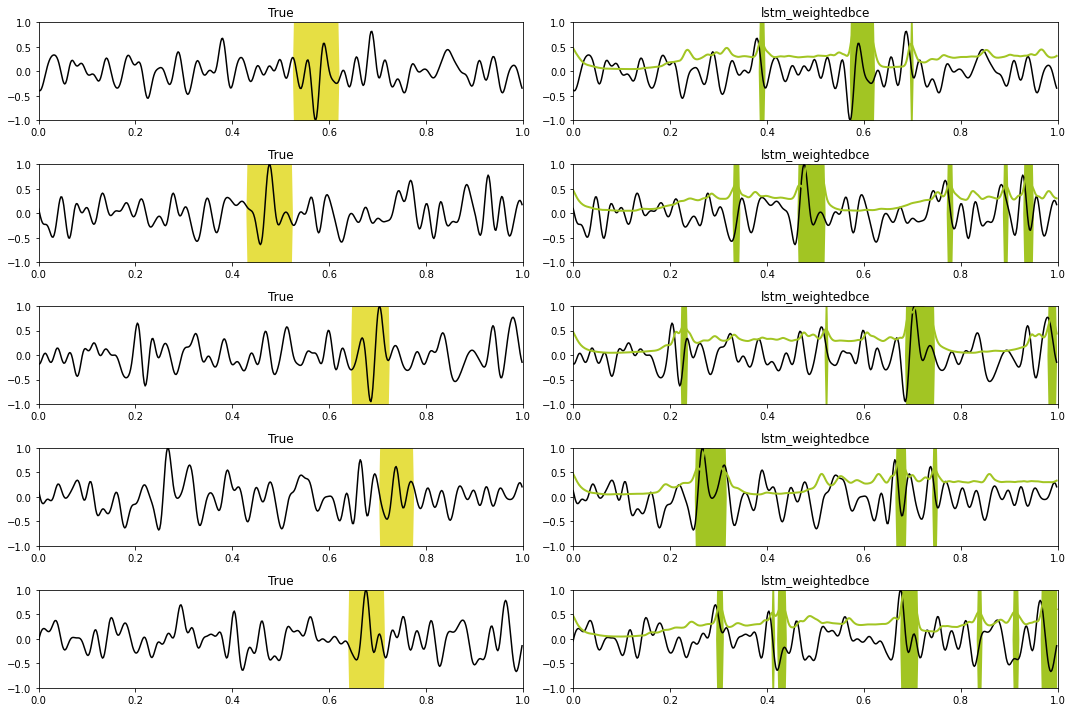

In [26]:
# Prediction train
X, y = next(iter(train_loader))
predict(network_w, X, y, model, device, dt=dt, nplot=5)

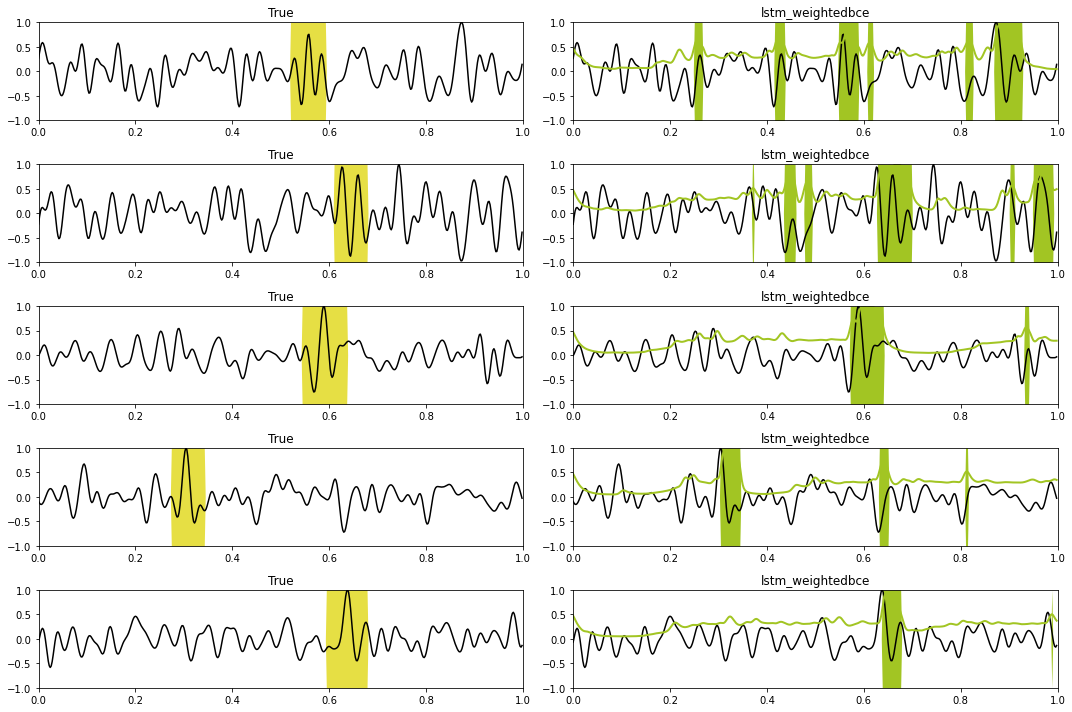

In [27]:
# Prediction test
X, y = next(iter(test_loader))
predict(network_w, X, y, model, device, dt=dt, nplot=5)

### LSTM with strongly Weighted BCE

Best epoch: 83, Valid accuracy: 0.94


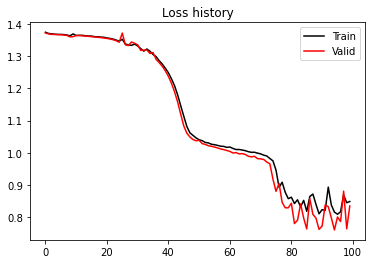

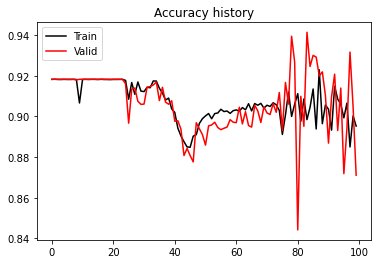

In [28]:
model = 'lstm_strongweightedbce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_w1 = LSTMNetwork(1, 200, 1)
    network_w1.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling+2, ]).to(device))
    optim = torch.optim.Adam(network_w1.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_w1, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    # Load best model
    network_w1 = LSTMNetwork(1, 200, 1)
    network_w1.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
    network_w1.to(device)
    
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']
    
print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

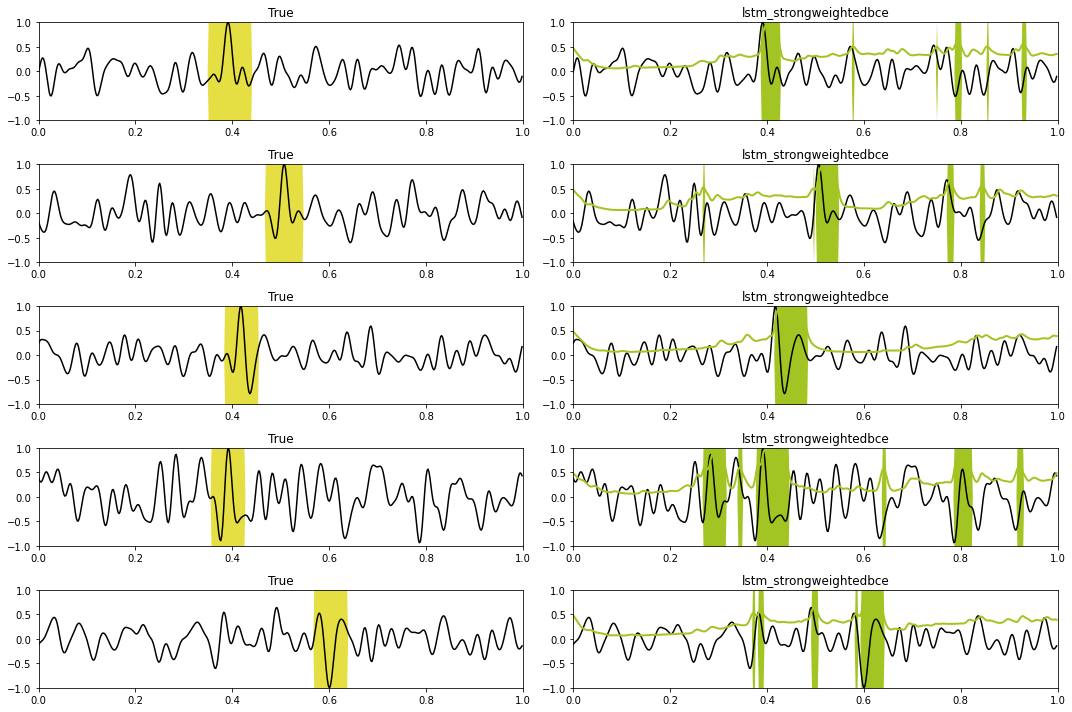

In [29]:
# Prediction train
X, y = next(iter(train_loader))
predict(network_w1, X, y, model, device, dt=dt, nplot=5)

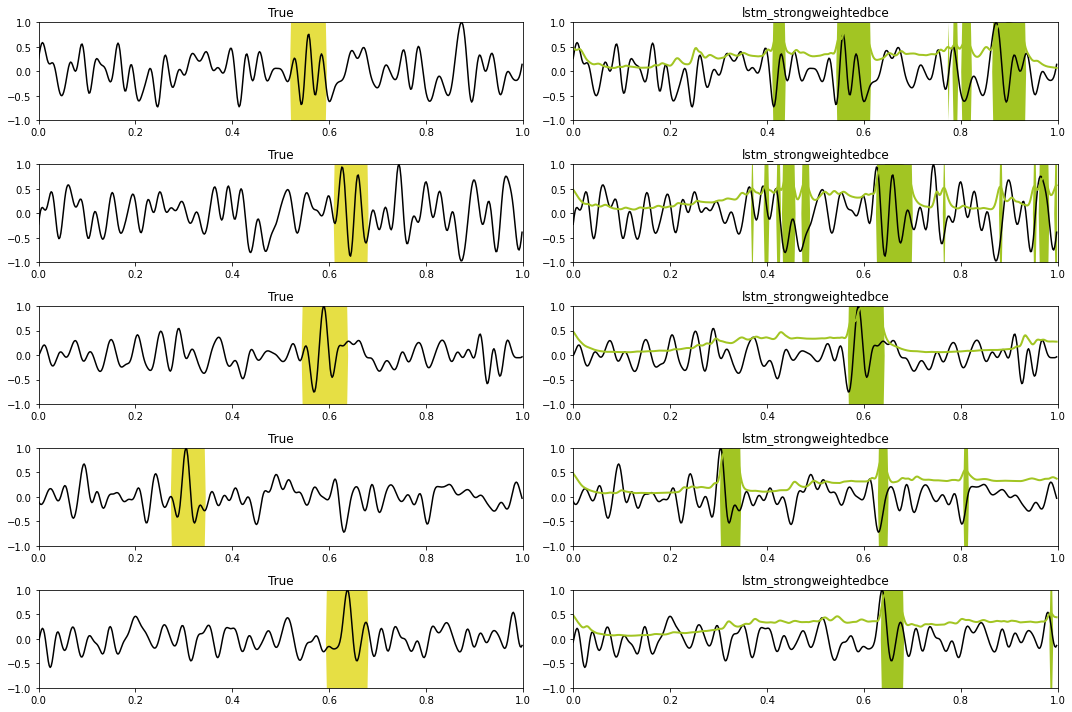

In [30]:
# Prediction test
X, y = next(iter(test_loader))
predict(network_w1, X, y, model, device, dt=dt, nplot=5)

### BidirLSTM

Best epoch: 98, Valid accuracy: 0.97


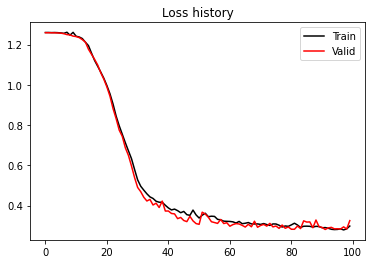

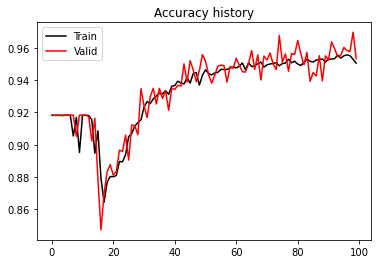

In [31]:
model = 'bilstm_weightedbce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_w2 = BiLSTMNetwork(1, 200, 1)
    network_w2.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network_w2.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_w2, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    # Load best model
    network_w2 = BiLSTMNetwork(1, 200, 1)
    network_w2.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
    network_w2.to(device)
    
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

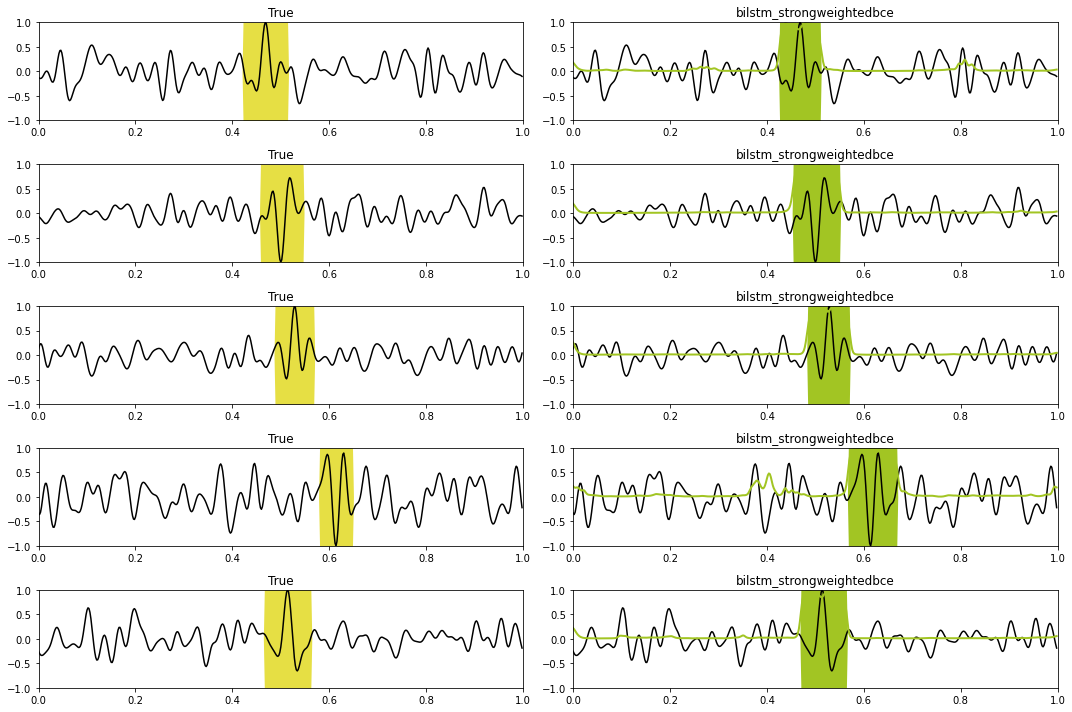

In [32]:
# Prediction train
X, y = next(iter(train_loader))
predict(network_w2, X, y, model, device, dt=dt, nplot=5)

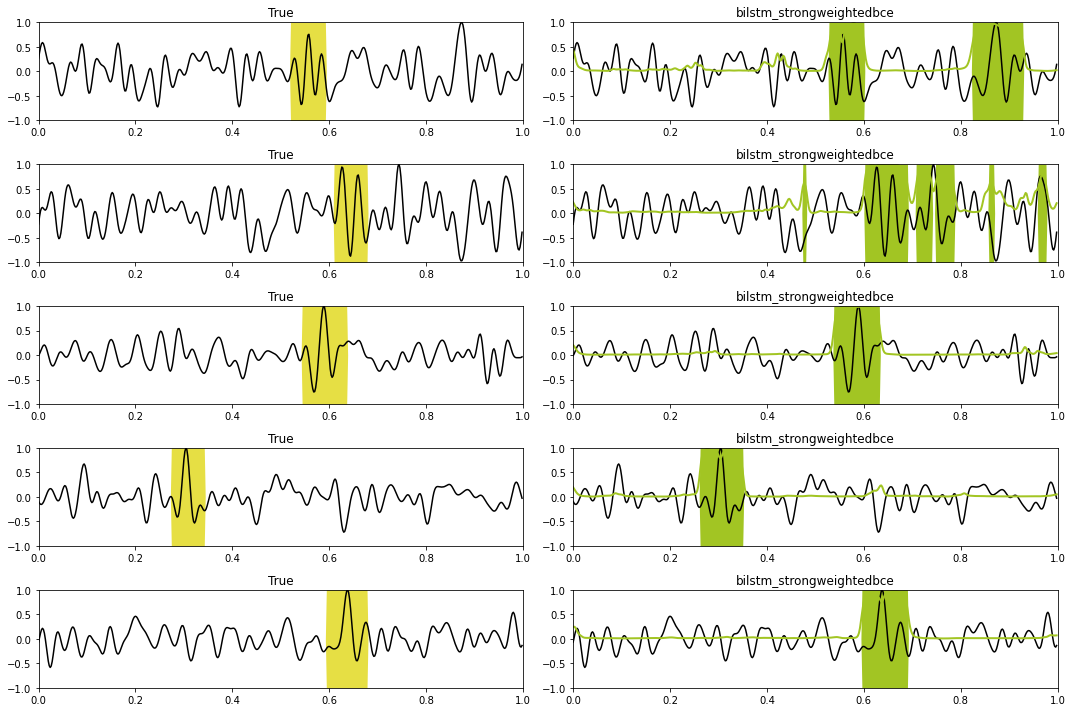

In [33]:
# Prediction test
X, y = next(iter(test_loader))
predict(network_w2, X, y, model, device, dt=dt, nplot=5)

### Double BidirLSTM

Best epoch: 92, Valid accuracy: 0.97


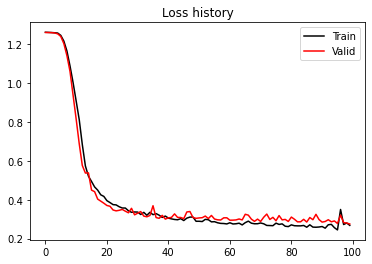

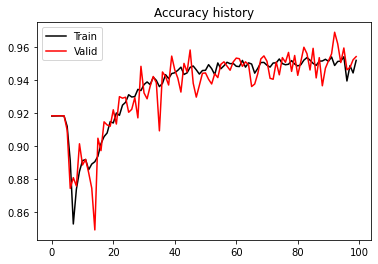

In [37]:
model = 'doublelstm_weightedbce'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_st = DoubleBiLSTMNetwork(1, 200, 100, 1)
    network_st.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network_st.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_st, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    # Load best model
    network_st = DoubleBiLSTMNetwork(1, 200, 100, 1)
    network_st.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
    network_st.to(device)
    
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

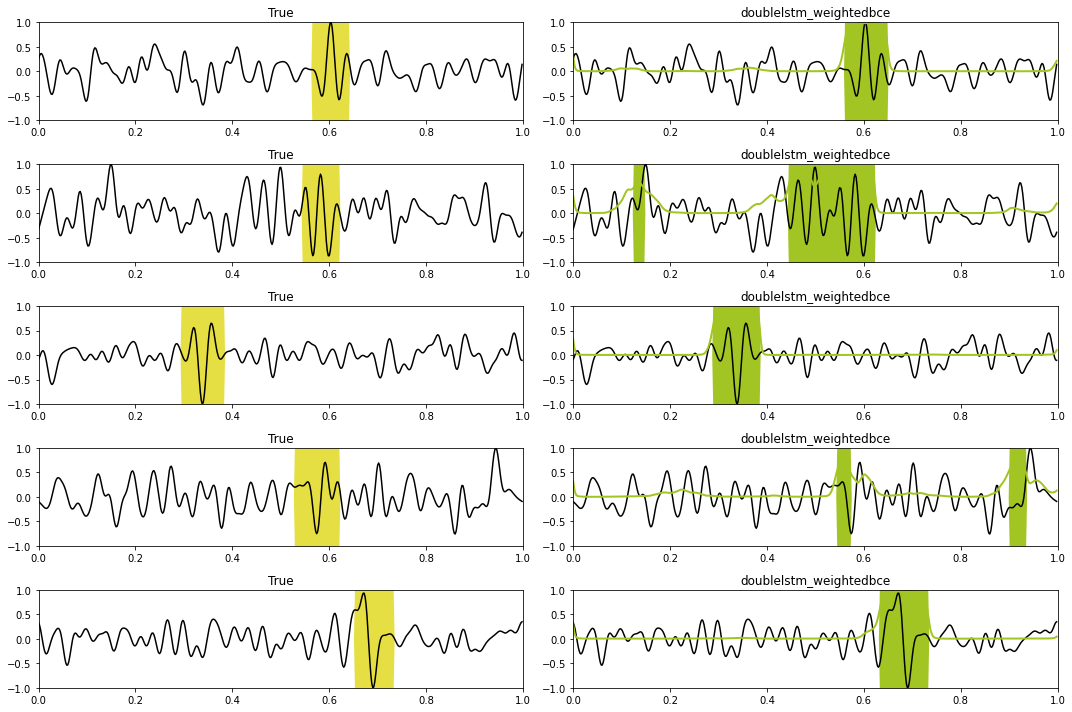

In [35]:
# Prediction train
X, y = next(iter(train_loader))
predict(network_st, X, y, model, device, dt=dt, nplot=5)

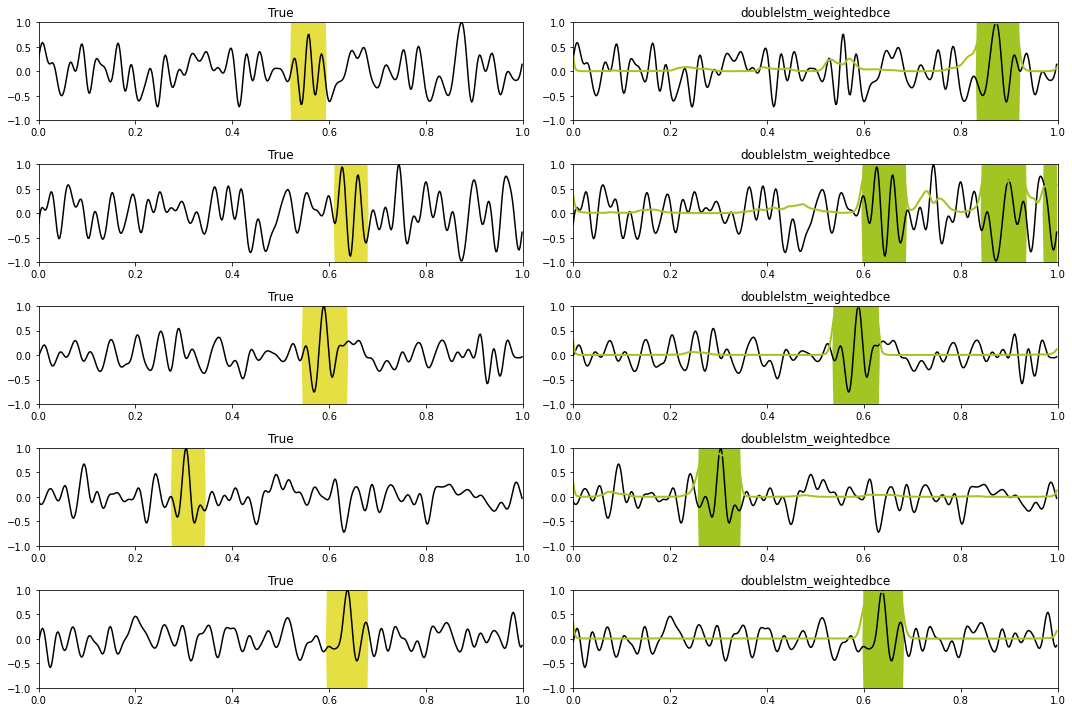

In [36]:
# Prediction test
X, y = next(iter(test_loader))
predict(network_st, X, y, model, device, dt=dt, nplot=5)